# Visualize Models

This notebook is used to analyze key structural metrics like average degree and spanning tree constant as well as to visualize the structure of different random graph models. These comparisons are useful for evaluating how well a model approximates real-world dual graphs derived from geographic maps.

In [1]:
# Import Libraries
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.patches import Patch
import pickle
import numpy as np
import importlib
import models
importlib.reload(models)
import networkx as nx
from gerrychain import Graph

## Model Comparison: Average Degree vs. Spanning Tree Constant
This section will explore how different models behave when comparing two key structural metrics:
- Average Degree: Mean number of neighbors per node in the graph.
- Spanning Tree Constant: Used as a compactness measure, calculated from the number of spanning trees in a graph.

In [2]:
# Read in the file containing all the data
df = pd.read_csv("csv_files/model_avgs.csv")

# Rename the model type column
df.rename( columns={'Unnamed: 0':'Model_Type'}, inplace=True )
df["Model_Type"] = df["Model_Type"].str.replace("Model", "").str.strip()

In [3]:
# Add Avg ST Cons to dataset
avg_st_cons = []

for model in df["Model_Type"]:
    with open(f'pkls/tree_const_m{model}.pkl', 'rb') as f:
        tree_const = pickle.load(f)
    avg_st_cons.append(np.mean(tree_const).round(2))

df["avg_st_con"] = avg_st_cons

In [4]:
# Set colors for plotting and distinguishing between models
model_colors = {
    "2": "darkgreen",
    "3": "cornflowerblue",
    "4": "indigo",
    "4b": "tab:purple",
    "5": "deeppink",
    "5b": "tab:pink",
    "6": "tab:orange",
    "7": "brown",
    "8": "tab:cyan",
    "9": "lightcoral",
    "9b": "indianred",
    "10": "tab:olive",
    "10b": "gold",
    "11": "springgreen",
    "11b": "forestgreen",
    "11c": "yellowgreen",
    "12": "darkcyan"
}
colors = df["Model_Type"].map(model_colors)

In [5]:
# Get values for the real data
rd_avg_deg = 5.4
with open(f'pkls/tree_const_real.pkl', 'rb') as f:
        tree_const = pickle.load(f)
        rd_st_cons = round(np.mean(tree_const), 2)

/var/folders/2w/nf45dfcn5c9cqf954vr1lz3r0000gn/T/ipykernel_76078/2357886309.py:5: UserWarning: You have used the `textcoords` kwarg, but not the `xytext` kwarg.  This can lead to surprising results.
  plt.annotate(f'Real Data', (rd_st_cons, rd_avg_deg), textcoords="offset pixels")


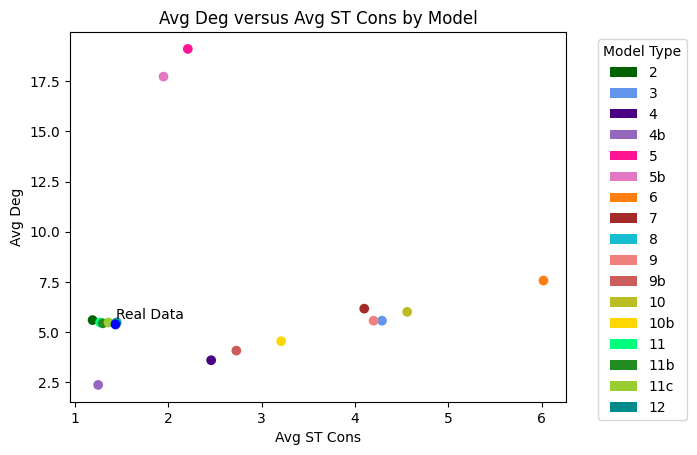

In [6]:
# Plot
plt.scatter(x=df["avg_st_con"], y=df["avg_deg"], c=colors)

plt.scatter(x=rd_st_cons, y=rd_avg_deg, c="blue")
plt.annotate(f'Real Data', (rd_st_cons, rd_avg_deg), textcoords="offset pixels")

plt.xlabel("Avg ST Cons")
plt.ylabel("Avg Deg")
legend_elements = [Patch(facecolor=color, label=label) for label, color in model_colors.items()]
plt.legend(handles=legend_elements, title="Model Type", bbox_to_anchor=(1.05, 1), loc='upper left')
plt.title("Avg Deg versus Avg ST Cons by Model")
plt.savefig(f'imgs/av_deg_st_cons_by_model.png')

/var/folders/2w/nf45dfcn5c9cqf954vr1lz3r0000gn/T/ipykernel_76078/2673557426.py:24: UserWarning: You have used the `textcoords` kwarg, but not the `xytext` kwarg.  This can lead to surprising results.
  plt.annotate("Real Data", (rd_st_cons, rd_avg_deg), textcoords="offset pixels")


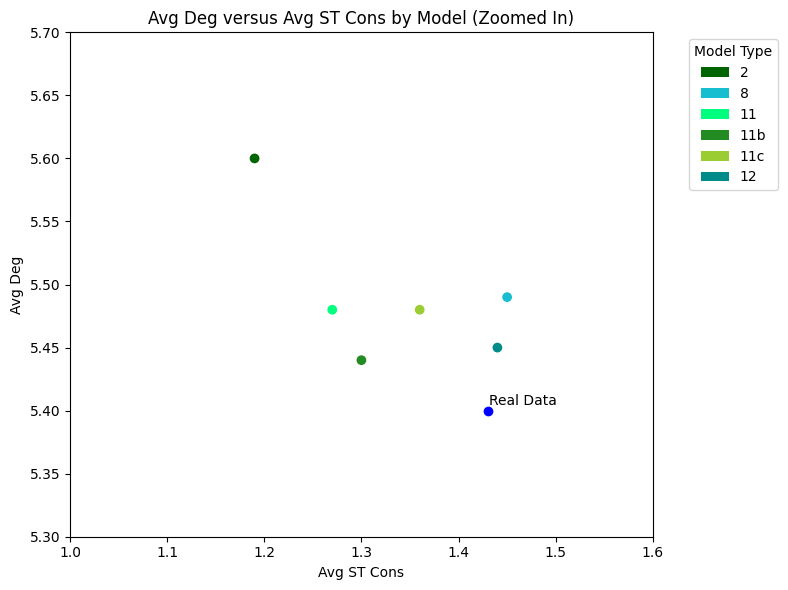

In [7]:
# Plot a graph zoomed on the results closest to the real data

# Define zoomed in region
x_min, x_max = 1, 1.6
y_min, y_max = 5.3, 5.7

# Filter df to just the visible points
visible_df = df[(df["avg_st_con"] >= x_min) & (df["avg_st_con"] <= x_max) &
                (df["avg_deg"] >= y_min) & (df["avg_deg"] <= y_max)]

# Also filter the colors array accordingly
visible_colors = [color for i, color in enumerate(colors) if df.index[i] in visible_df.index]

# Create new model_colors dictionary just for the visible models
visible_model_types = visible_df["Model_Type"].unique()
visible_model_colors = {label: model_colors[label] for label in visible_model_types}

# Plot
plt.figure(figsize=(8, 6))
plt.scatter(x=visible_df["avg_st_con"], y=visible_df["avg_deg"], 
            c=visible_colors)

plt.scatter(x=rd_st_cons, y=rd_avg_deg, c="blue")
plt.annotate("Real Data", (rd_st_cons, rd_avg_deg), textcoords="offset pixels")

plt.xlabel("Avg ST Cons")
plt.ylabel("Avg Deg")
legend_elements = [Patch(facecolor=color, label=label) for label, color in visible_model_colors.items()]
plt.legend(handles=legend_elements, title="Model Type", bbox_to_anchor=(1.05, 1), loc='upper left')
plt.title("Avg Deg versus Avg ST Cons by Model (Zoomed In)")
plt.xlim(x_min, x_max)
plt.ylim(y_min, y_max)
plt.tight_layout()
plt.savefig("imgs/av_deg_st_cons_by_model_zoomed_in.png")

## Add real data values to the model results dataset and save as csv
The values for the real data were calculated in the file `real_graph_exploration/degree_exploration.ipynb`.

In [8]:
df.loc[-1] = ["Real Data", 0.72, 0.89, 5.42, 5.00, 24.28, rd_st_cons]
df.index = df.index + 1
df.sort_index(inplace=True) 
df.to_csv("csv_files/model_avgs_st_cons.csv", index=False)

## Visualize Top-Performing Models
Based on earlier analysis, Model Eight, Model Eleven, and Model Twelve produced the closest matches to real-world dual graphs in terms of structural features such as degree distribution and spanning tree constant.

In this section, we visualize these top models using multiple random seeds to better understand their structural behavior. The goal is to assess whether their connectivity patterns, clustering, and spread reflect those observed in actual geographic graphs used in redistricting. These visualizations help identify artifacts like improbable long-range connections or unrealistic clumping, which may not be captured by summary statistics alone.

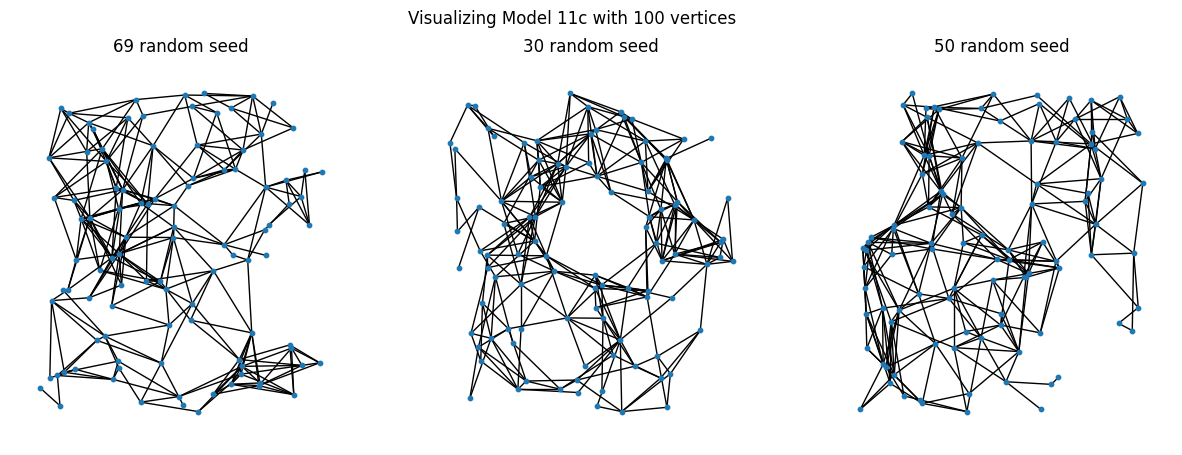

In [9]:
model = "11c"
n = 100
rs = [69, 30, 50]

fig, ax = plt.subplots(1, len(rs), figsize=(15, 5))

if model == "8":
    for i in range(len(rs)):
        G = models.model_eight(n, rs[i])
        node_locations = {v: (float(G.nodes()[v]['x_axis']), float(G.nodes()[v]['y_axis'])) for v in G.nodes()}
        nx.draw(G, node_size = 10, pos = node_locations, ax=ax[i])
        ax[i].set_title(f'{rs[i]} random seed')
elif model == "11c":
    for i in range(len(rs)):
        G = models.model_two_rand_removal(n, rs[i], scaling_factor=14, remove_prob=0.6)
        node_locations = {v: (float(G.nodes()[v]['x_axis']), float(G.nodes()[v]['y_axis'])) for v in G.nodes()}
        nx.draw(G, node_size = 10, pos = node_locations, ax=ax[i])
        ax[i].set_title(f'{rs[i]} random seed')
elif model == "12":
    for i in range(len(rs)):
        G = models.model_eight_order_switched(n, rs[i])
        node_locations = {v: (float(G.nodes()[v]['x_axis']), float(G.nodes()[v]['y_axis'])) for v in G.nodes()}
        nx.draw(G, node_size = 10, pos = node_locations, ax=ax[i])
        ax[i].set_title(f'{rs[i]} random seed')

fig.suptitle(f"Visualizing Model {model} with {n} vertices")
plt.savefig(f'imgs/visualize_model{model}.png')

## Visualize a Delaunay Triangulation (Model 3)

In this section, we visualize Model 3, which is based on a Delaunay triangulation. Since this type of graph may be unfamiliar to some readers, we include a visualization to help illustrate its structure. 

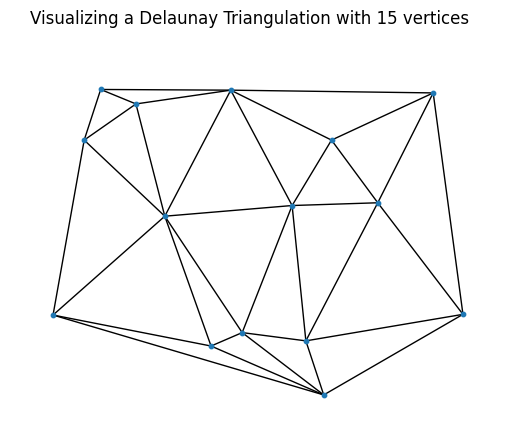

In [10]:
n = 15
G = models.model_three(n, 50)
node_locations = {v: (float(G.nodes()[v]['x_axis']), float(G.nodes()[v]['y_axis'])) for v in G.nodes()}

fig, ax = plt.subplots(1)
nx.draw(G, node_size = 10, pos = node_locations)
fig.suptitle(f"Visualizing a Delaunay Triangulation with {n} vertices")
plt.savefig(f'imgs/visualize_dt.png')